1. From Uniprot get similarity matrix
2. Find clusters by simlarity
3. Split target share test set by clusters and visulize the result by plotting target name in train and test set
4. Split similarity share test, random share test sequencially and combine as one csv in the end

In [1]:
import numpy as np
import pandas as pd
from biotite.sequence import ProteinSequence
from biotite.sequence.align import align_optimal, SubstitutionMatrix
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.ML.Cluster import Butina
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import warnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
from collections import defaultdict
from rdkit import DataStructs
import sys
import os
project_path = os.path.abspath('../PROTAC-Degradation-Predictor')
sys.path.append(project_path)
sys.path.append('../protac_degradation_predictor')
import protac_degradation_predictor as pdp

            Q07817      P00533      Q9NWZ3      P00519      P11474     Q16288  \
Q07817  100.000000   12.975207   18.913043   13.982301   21.513002  16.328963   
P00533   12.975207  100.000000   18.181818   16.115702   17.438017  20.413223   
Q9NWZ3   18.913043   18.181818  100.000000   17.699115   14.565217  20.619785   
P00519   13.982301   16.115702   17.699115  100.000000   19.203540  20.530973   
P11474   21.513002   17.438017   14.565217   19.203540  100.000000  19.666269   
...            ...         ...         ...         ...         ...        ...   
Q96C86   20.474777   16.115702   19.782609   16.991150   21.040189  17.520858   
P14625   15.193026   19.917355   19.800747   18.584071   19.427148  13.945173   
P06493   19.528620   14.793388   21.086957   15.752212   20.330969  16.567342   
P27361   18.997361   16.859504   16.304348   16.814159   14.893617  18.712753   
Q9C5S2   15.576694   20.082645   20.689655   20.176991   21.521998  12.604043   

           O60674     Q0618

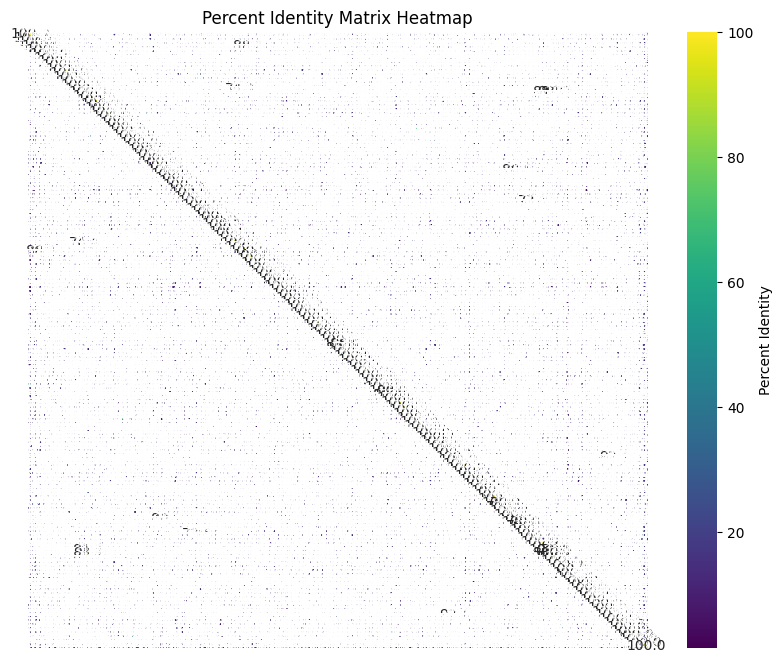

In [16]:
# get similarity matrix

# Read and clean the data, remove sequences containing 'U'
df = pd.read_csv('../data/PROTAC_combined_sasa.csv')
# df['POI Sequence'] = df['POI Sequence'].apply(lambda x: x if isinstance(x, str) and 'U' not in x else None)
df['POI Sequence'] = df['POI Sequence'].apply(lambda x: x.replace('U', 'C') if isinstance(x, str) else None)
df.dropna(subset=['POI Sequence'], inplace=True)

# Remove duplicates and keep only unique POI Sequences
df_unique = df.drop_duplicates(subset=['POI Sequence'])
uniprot_ids = df_unique['Uniprot'].tolist()

# Create ProteinSequence objects
sequences = [ProteinSequence(seq) for seq in df_unique['POI Sequence'].tolist()]

# Define necessary variables
num_sequences = len(sequences)

# Initialize the percent identity matrix
percent_identity_matrix = np.zeros((num_sequences, num_sequences))

# Use the standard BLOSUM62 substitution matrix
substitution_matrix = SubstitutionMatrix.std_protein_matrix()

# Compute the identity matrix
for i in range(num_sequences):
    for j in range(i, num_sequences):
        seq1 = sequences[i]
        seq2 = sequences[j]

        # Perform global alignment
        alignments = align_optimal(seq1, seq2, substitution_matrix, local=False)
        alignment = alignments[0]
        aligned_seq1, aligned_seq2 = alignment.get_gapped_sequences()

        # Count the number of matching characters
        matched_chars = sum(a == b for a, b in zip(aligned_seq1, aligned_seq2) if a != '-' and b != '-')
        total_length = max(len(seq1), len(seq2))

        # Calculate percent identity
        identity_percentage = (matched_chars / total_length) * 100
        percent_identity_matrix[i, j] = identity_percentage
        percent_identity_matrix[j, i] = identity_percentage

# Create a DataFrame
percent_identity_df = pd.DataFrame(
    percent_identity_matrix,
    index=uniprot_ids,
    columns=uniprot_ids
)

# Print the matrix (example)
print(percent_identity_df)

# Plot a heatmap without axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(percent_identity_df, cmap="viridis", annot=True, fmt=".1f", cbar_kws={'label': 'Percent Identity'})
plt.title("Percent Identity Matrix Heatmap")
# Here we explicitly hide the x and y axis labels for a cleaner figure
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
percent_identity_df.to_csv('../data/percent_identity_matrix_U2C.csv')

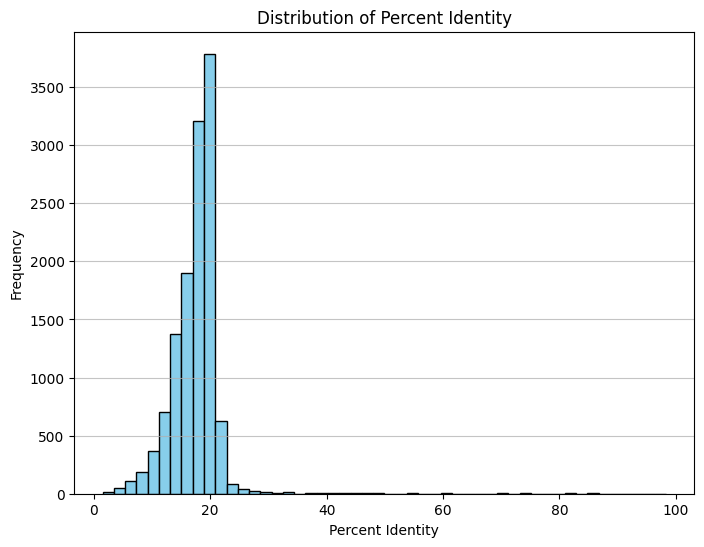

In [19]:
# Extract off-diagonal percent identity values for distribution histogram
identity_values = percent_identity_matrix[np.triu_indices(num_sequences, k=1)]

# Plot histogram of percent identity distribution
plt.figure(figsize=(8, 6))
plt.hist(identity_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Percent Identity")
plt.xlabel("Percent Identity")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

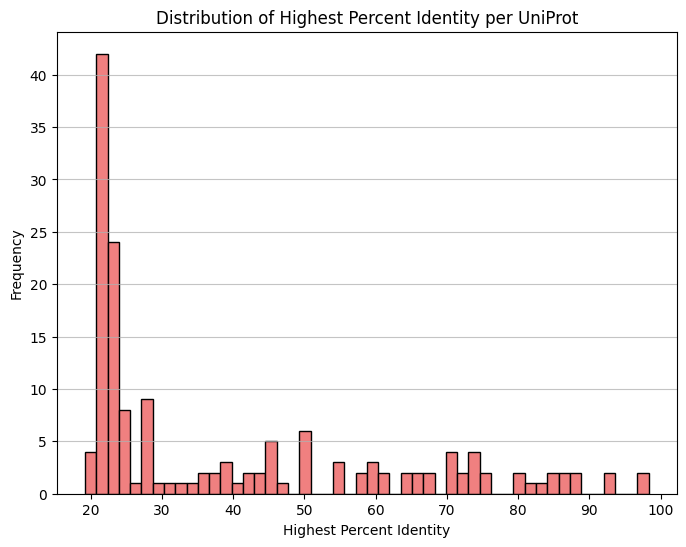

In [6]:
# Extract the highest percent identity for each sequence, ignoring the diagonal (self-comparison)
highest_identity_per_uniprot = []
for i in range(num_sequences):
    # Ignore the 100% self-match on the diagonal, find the max value compared to other sequences
    highest_identity = np.max(percent_identity_matrix[i, np.arange(num_sequences) != i])
    highest_identity_per_uniprot.append(highest_identity)

# Convert to Numpy array
highest_identity_per_uniprot = np.array(highest_identity_per_uniprot)

# Plot the distribution histogram of highest percent identity
plt.figure(figsize=(8, 6))
plt.hist(highest_identity_per_uniprot, bins=50, color='lightcoral', edgecolor='black')
plt.title("Distribution of Highest Percent Identity per UniProt")
plt.xlabel("Highest Percent Identity")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [3]:
percent_identity_df = pd.read_csv('../data/percent_identity_matrix_U2C.csv', index_col=0)  # load identity matrx

In [4]:
percent_identity_df.head()

,Q07817,P00533,Q9NWZ3,P00519,P11474,Q16288,O60674,Q06187,Q9UHD2,Q8IXJ6,...,Q8TBX8,P51692,P29597,P23458,O96028,Q96C86,P14625,P06493,P27361,Q9C5S2
Q07817,100.000000,12.975207,18.913043,13.982301,21.513002,16.328963,13.427562,18.968134,17.009602,20.308483,...,19.477435,17.026684,13.563606,13.258232,12.600733,20.474777,15.193026,19.528620,18.997361,15.576694
P00533,12.975207,100.000000,18.181818,16.115702,17.438017,20.413223,14.793388,21.735537,20.743802,17.107438,...,17.685950,19.752066,13.471074,12.975207,15.604396,16.115702,19.917355,14.793388,16.859504,20.082645
Q9NWZ3,18.913043,18.181818,100.000000,17.699115,14.565217,20.619785,19.434629,19.575114,20.438957,17.173913,...,18.695652,19.695044,18.197136,19.497400,17.948718,19.782609,19.800747,21.086957,16.304348,20.689655
P00519,13.982301,16.115702,17.699115,100.000000,19.203540,20.530973,13.692580,20.353982,20.176991,18.318584,...,18.230088,19.380531,13.732098,14.818024,18.461538,16.991150,18.584071,15.752212,16.814159,20.176991
P11474,21.513002,17.438017,14.565217,19.203540,100.000000,19.666269,18.021201,20.182094,19.890261,14.657210,...,16.312057,20.965693,19.039596,17.937608,16.703297,21.040189,19.427148,20.330969,14.893617,21.521998


In [21]:
# #butina -- same result

# similarity_matrix = percent_identity_df.to_numpy() / 100.0

# distance_matrix = 1 - similarity_matrix

# condensed_distance_matrix = distance_matrix[np.tril_indices_from(distance_matrix, k=-1)]

# threshold = 0.3  

# clusters = Butina.ClusterData(condensed_distance_matrix, len(similarity_matrix), threshold, isDistData=True)

# for cluster in clusters:
#     print(cluster)

(135, 15, 133, 134)
(150, 109)
(129, 43)
(127, 126)
(125, 35)
(122, 121)
(99, 24)
(93, 92)
(81, 80)
(76, 75)
(56, 3)
(54, 14)
(158,)
(157,)
(156,)
(155,)
(154,)
(153,)
(152,)
(151,)
(149,)
(148,)
(147,)
(146,)
(145,)
(144,)
(143,)
(142,)
(141,)
(140,)
(139,)
(138,)
(137,)
(136,)
(132,)
(131,)
(130,)
(128,)
(124,)
(123,)
(120,)
(119,)
(118,)
(117,)
(116,)
(115,)
(114,)
(113,)
(112,)
(111,)
(110,)
(108,)
(107,)
(106,)
(105,)
(104,)
(103,)
(102,)
(101,)
(100,)
(98,)
(97,)
(96,)
(95,)
(94,)
(91,)
(90,)
(89,)
(88,)
(87,)
(86,)
(85,)
(84,)
(83,)
(82,)
(79,)
(78,)
(77,)
(74,)
(73,)
(72,)
(71,)
(70,)
(69,)
(68,)
(67,)
(66,)
(65,)
(64,)
(63,)
(62,)
(61,)
(60,)
(59,)
(58,)
(57,)
(55,)
(53,)
(52,)
(51,)
(50,)
(49,)
(48,)
(47,)
(46,)
(45,)
(44,)
(42,)
(41,)
(40,)
(39,)
(38,)
(37,)
(36,)
(34,)
(33,)
(32,)
(31,)
(30,)
(29,)
(28,)
(27,)
(26,)
(25,)
(23,)
(22,)
(21,)
(20,)
(19,)
(18,)
(17,)
(16,)
(13,)
(12,)
(11,)
(10,)
(9,)
(8,)
(7,)
(6,)
(5,)
(4,)
(2,)
(1,)
(0,)


In [5]:

clusters = {}

threshold = 70
cluster_id = 0

for index, row in percent_identity_df.iterrows():
    current_id = index
  
    similar_ids = row[row > threshold].index.tolist()

    if not similar_ids:
        clusters[current_id] = cluster_id
        cluster_id += 1
    else:

        found_cluster = cluster_id
        cluster_id += 1
        clusters[current_id] = found_cluster
        for uni_id in similar_ids:
            clusters[uni_id] = found_cluster

cluster_df = pd.DataFrame(list(clusters.items()), columns=['Uniprot', 'Cluster'])
print(cluster_df)

    Uniprot  Cluster
0    Q07817        0
1    P00533        1
2    Q9NWZ3        2
3    P00519       56
4    P00520       56
..      ...      ...
154  Q96C86      154
155  P14625      155
156  P06493      156
157  P27361      157
158  Q9C5S2      158

[159 rows x 2 columns]


In [6]:
# Use pandas' groupby and size methods to calculate statistics
cluster_summary = cluster_df.groupby('Cluster').size()

# Print the total number of unique clusters
num_unique_clusters = cluster_summary.shape[0]
print(f"Total number of unique clusters: {num_unique_clusters}")

# Calculate the size of each cluster using groupby and size methods
cluster_sizes = cluster_df.groupby('Cluster').size()

# Use value_counts to determine the number of clusters of different sizes
cluster_size_distribution = cluster_sizes.value_counts().sort_index()

# Print the number of clusters with different numbers of Uniprot entries
print("Number of clusters with different numbers of Uniprot entries:")
for size, count in cluster_size_distribution.items():
    print(f"Number of clusters with {size} Uniprot(s): {count}")

Total number of unique clusters: 145
Number of clusters with different numbers of Uniprot entries:
Number of clusters with 1 Uniprot(s): 133
Number of clusters with 2 Uniprot(s): 11
Number of clusters with 4 Uniprot(s): 1


In [25]:
data_df = pd.read_csv('../data/PROTAC-Degradation-DB-2025.csv') #load data that need to be splitted

In [26]:
# Filter out rows where Dmax (%) is null
non_null_dmax_df = data_df[data_df['DC50 (nM)'].notna()]

# Get the number of unique Uniprot entries
unique_uniprot_count = non_null_dmax_df['Uniprot'].nunique()

print(f"Number of unique Uniprot entries: {unique_uniprot_count}")

Number of unique Uniprot entries: 149


In [34]:
# Target splitting, process:
# load data, clear data by remove dublicates
# group the data by Uniprot
# If Uniprot in multi_uniprot_clusters, means those Uniprot are simiar, split into training set
# Then randomly split out the amount of training set by taking out Uniprot in single_uniprot_clusters

def merge_numerical_cols(group: pd.DataFrame) -> pd.DataFrame:
    """ when remove duplicates with key columns is the same, merge the numerical columns by computing the geometric mean
    """
    key_cols = [
        'Smiles',
        'Uniprot',
        'E3 Ligase Uniprot',
        'Cell Line Identifier',
    ]
    class_cols = ['DC50 (nM)', 'Dmax (%)']
    # Loop over all numerical columns
    for col in group.select_dtypes(include=[np.number]).columns:
        if col == 'Compound ID':
            continue
        # Compute the geometric mean for the column
        values = group[col].dropna()
        if not values.empty:
            group[col] = np.prod(values) ** (1 / len(values))

    row = group.drop_duplicates(subset=key_cols + class_cols).reset_index(drop=True)

    assert len(row) == 1

    return row

def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """ Remove duplicates from the DataFrame.
    """
    key_cols = [
        'Smiles',
        'Uniprot',
        'E3 Ligase Uniprot',
        'Cell Line Identifier',
    ]
    class_cols = ['DC50 (nM)', 'Dmax (%)']
    # Check if there are any duplicated entries having the same key columns, if
    # so, merge them by applying a geometric mean to their DC50 and Dmax columns
    duplicated = df[df.duplicated(subset=key_cols, keep=False)]

    # NOTE: Reset index to remove the multi-index
    merged = duplicated.groupby(key_cols).apply(lambda x: merge_numerical_cols(x))
    merged = merged.reset_index(drop=True)

    # Remove the duplicated entries from the original dataframe df
    df = df[~df.duplicated(subset=key_cols, keep=False)]
    # Concatenate the merged dataframe with the original dataframe
    return pd.concat([df, merged], ignore_index=True)


def target_split_by_uniprot_cluster(
    data_df: pd.DataFrame,
    cluster_df: pd.DataFrame,
    uniprot_col: str = "Uniprot",
    cluster_col: str = "Cluster",
    value_col: str = "DC50 (nM)",
    train_ratio: float = 0.9,
    random_seed: int = 42
):
    """
    Split the dataset into training and testing sets using Uniprot-cluster logic.
    Entries in clusters with multiple Uniprot are always fully assigned to training set.
    The rest are shuffled and assigned to training until train_ratio is satisfied.

    Args:
        data_df (pd.DataFrame): Full dataset (should include `Uniprot` column).
        cluster_df (pd.DataFrame): DataFrame with columns ['Uniprot', 'Cluster'] at least.
        uniprot_col (str): Name of Uniprot column.
        cluster_col (str): Name of cluster column in cluster_df.
        value_col (str): Name of column used for regression/classification ('DC50 (nM)').
        train_ratio (float): The fraction of all entries to assign to training.
        random_seed (int): Random seed for reproducibility.

    Returns:
        train_df (pd.DataFrame): Training set.
        test_df (pd.DataFrame): Test set.

    """

    # Drop missing values in the relevant value column
    data_df = data_df[data_df[value_col].notna()].copy()
    data_df = data_df[data_df[uniprot_col].notna()]
    
    # Merge cluster info
    if cluster_col not in data_df.columns:
        data_df = data_df.merge(cluster_df[[uniprot_col, cluster_col]], on=uniprot_col, how='left')
    
    # Get clusters with multiple/single Uniprot entries
    cluster_sizes = cluster_df.groupby(cluster_col).size()
    multi_uniprot_clusters = cluster_sizes[cluster_sizes > 1].index
    single_uniprot_clusters = cluster_sizes[cluster_sizes == 1].index

    multi_uniprot_ids = cluster_df[cluster_df[cluster_col].isin(multi_uniprot_clusters)][uniprot_col]
    single_uniprot_ids = cluster_df[cluster_df[cluster_col].isin(single_uniprot_clusters)][uniprot_col]

    multi_uniprot_df = data_df[data_df[uniprot_col].isin(multi_uniprot_ids)]
    single_uniprot_df = data_df[data_df[uniprot_col].isin(single_uniprot_ids)]

    # Shuffle unique single Uniprot IDs
    unique_single_uniprots = single_uniprot_df[uniprot_col].unique()
    np.random.seed(random_seed)
    np.random.shuffle(unique_single_uniprots)

    # Determine split sizes
    total_entries = len(data_df)
    desired_train_size = int(train_ratio * total_entries)
    current_train_size = len(multi_uniprot_df)

    # Assign single Uniprot entries to train set until train set is full
    train_uniprot_count = 0
    training_uniprot_ids = []
    for uniprot in unique_single_uniprots:
        uniprot_group = single_uniprot_df[single_uniprot_df[uniprot_col] == uniprot]
        if train_uniprot_count + len(uniprot_group) > desired_train_size - current_train_size:
            break
        training_uniprot_ids.append(uniprot)
        train_uniprot_count += len(uniprot_group)
        
    train_single_df = single_uniprot_df[single_uniprot_df[uniprot_col].isin(training_uniprot_ids)]
    test_single_df = single_uniprot_df[~single_uniprot_df[uniprot_col].isin(training_uniprot_ids)]
    train_df = pd.concat([multi_uniprot_df, train_single_df], ignore_index=True)
    test_df = test_single_df.reset_index(drop=True)

    print(f"Training set contains {len(train_df)} entries.")
    print(f"Test set contains {len(test_df)} entries.")
    print(f"Sum of train and test: {len(train_df) + len(test_df)} (should equal original {total_entries})")
    return train_df, test_df

# Dmax/DC50 target splitting
data_df = pd.read_csv('../data/PROTAC-Degradation-DB-2025.csv')
cluster_df =  cluster_df # ensure it has Uniprot, Cluster
train_df, test_df = target_split_by_uniprot_cluster(
    data_df=data_df,
    cluster_df=cluster_df,
    uniprot_col='Uniprot',
    cluster_col='Cluster',
    value_col='DC50 (nM)',
    train_ratio=0.967, # split out 3.3% target test set for share test set
    random_seed=42
)

# 'Active (Dmax 0.6, pDC50 6.0)' target splitting
# # Load data
# active_col: str = 'Active (Dmax 0.6, pDC50 6.0)'
# active_name = active_col.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '')
# Dmax_threshold = float(active_col.split('Dmax')[1].split(',')[0].strip('(').strip(')').strip())
# pDC50_threshold = float(active_col.split('pDC50')[1].strip('(').strip(')').strip())

# protac_df = pd.read_csv('../data/PROTAC-Degradation-DB-2025.csv')

# protac_df = remove_duplicates(protac_df)
   
# protac_df[active_col] = protac_df.apply(
#         lambda x: pdp.is_active(x['DC50 (nM)'], x['Dmax (%)'], pDC50_threshold=pDC50_threshold, Dmax_threshold=Dmax_threshold), axis=1
#     )

# active_df = protac_df[protac_df[active_col].notna()].copy()

# train_df, test_df = target_split_by_uniprot_cluster(
#     data_df=active_df,
#     cluster_df=cluster_df,
#     uniprot_col='Uniprot',
#     cluster_col='Cluster',
#     value_col='Active (Dmax 0.6, pDC50 6.0)',
#     train_ratio=0.9,
#     random_seed=42
# )

1476
Number of missing Uniprot values (NaN or None): 4
1472
desired_train_size: 1423
current_train_size 211
Training set contains 1423 entries.
Test set contains 49 entries.
Sum of train and test: 1472


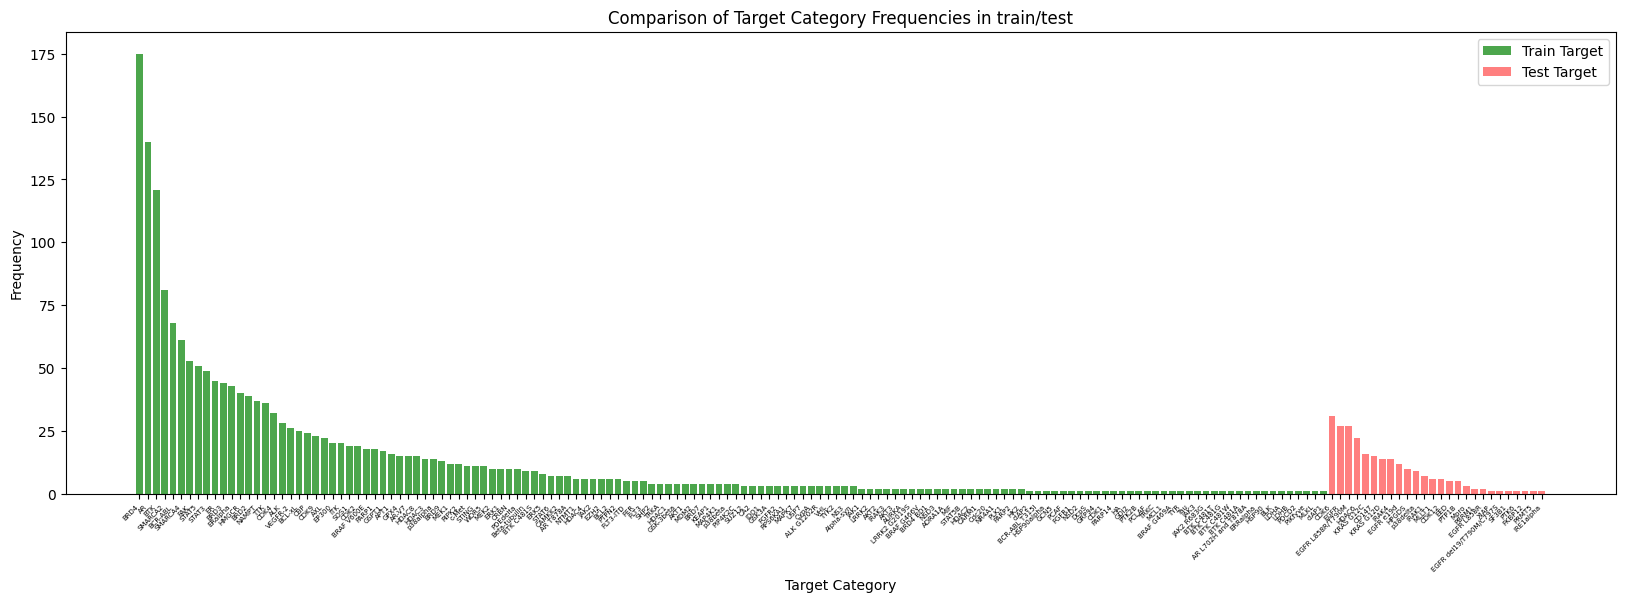

In [9]:
#target splitting visualization

# Calculate the frequency of each category
df1_counts = train_df['Target'].value_counts()
df2_counts = test_df['Target'].value_counts()

# Create a new plot
plt.figure(figsize=(20, 6))

# Plot the bar chart for the first DataFrame
plt.bar(df1_counts.index, df1_counts.values, alpha=0.7, label='Train Target', color='green')

# Plot the bar chart for the second DataFrame (slightly shifted to the right)
plt.bar(df2_counts.index, df2_counts.values, alpha=0.5, label='Test Target', color='red')

plt.title('Comparison of Target Category Frequencies in train/test')
plt.xlabel('Target Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right', fontsize=5)
plt.legend()
plt.show()

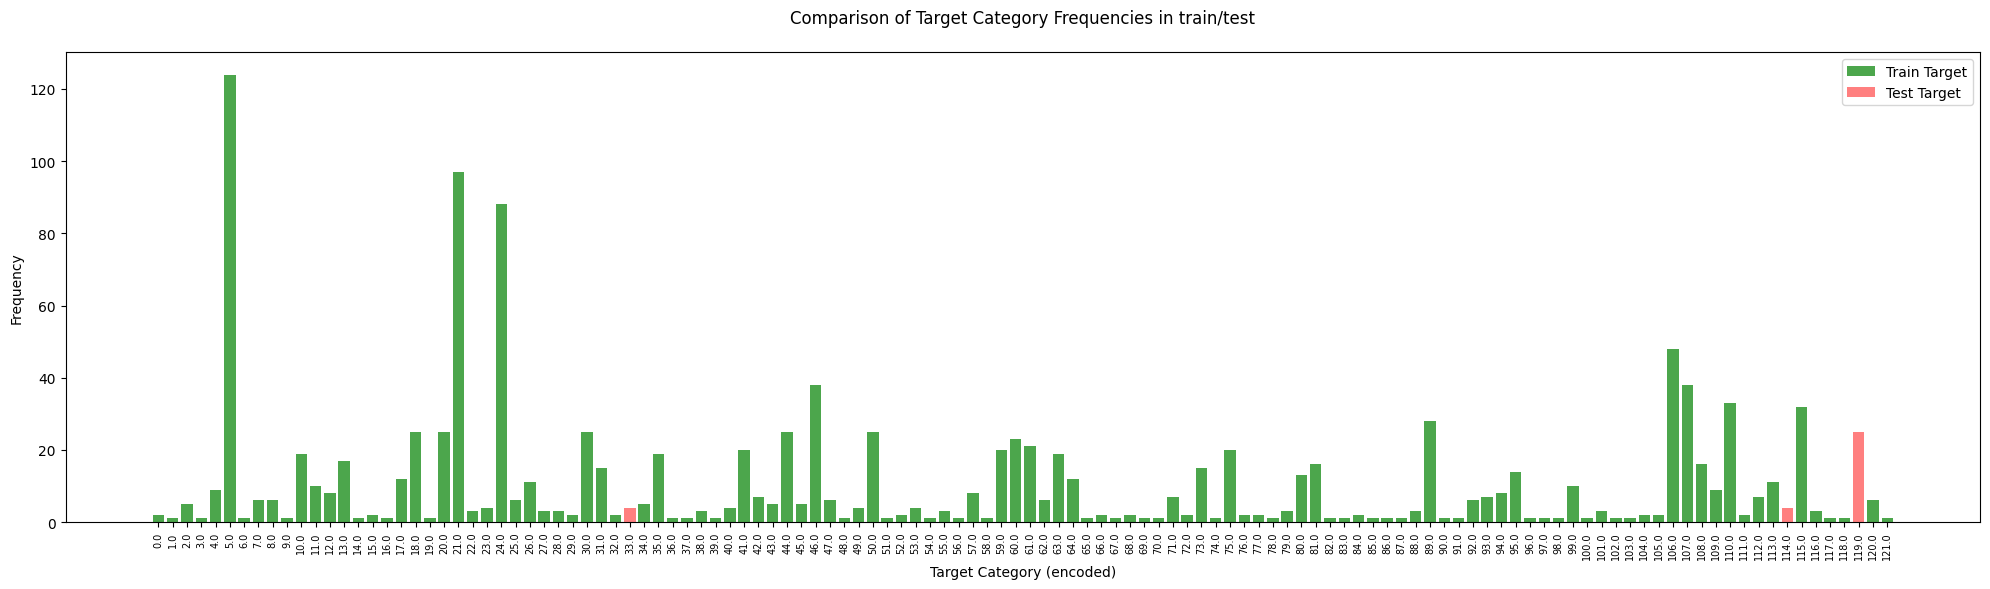

Number of overlapping targets: 0
No overlapping targets between Train and Test (excluding "na").


In [35]:
# Mapping target names to numbers for better visualization

# Standardize target names
def clean_target(x):
    if pd.isna(x):
        return 'NA'
    # If the value is a number and an integer, convert to string (remove decimal point)
    if isinstance(x, (int, float)):
        if x == int(x):
            return str(int(x))
        else:
            return str(x)
    # Otherwise, convert to lowercase and strip whitespace
    return str(x).lower().strip()

train_targets = train_df['Target'].apply(clean_target)
test_targets = test_df['Target'].apply(clean_target)
# Remove 'NA'
train_targets_no_na = train_targets[train_targets != 'NA']
test_targets_no_na = test_targets[test_targets != 'NA']

# Remap to new indices (target names to numbers)
all_targets = sorted(set(train_targets_no_na) | set(test_targets_no_na))
target2id = {t: i for i, t in enumerate(all_targets)}

# Map the indices to DataFrames
train_df['Target_id'] = train_targets_no_na.map(target2id)
test_df['Target_id'] = test_targets_no_na.map(target2id)

# Count frequencies and fill missing values with zero
train_counts_num = train_df['Target_id'].value_counts().sort_index()
test_counts_num = test_df['Target_id'].value_counts().sort_index()
all_ids = sorted(set(train_counts_num.index) | set(test_counts_num.index))
train_counts = train_counts_num.reindex(all_ids, fill_value=0)
test_counts = test_counts_num.reindex(all_ids, fill_value=0)

# Plot the frequencies for each target category (encoded)
plt.figure(figsize=(20, 6))
plt.bar(all_ids, train_counts.values, alpha=0.7, label='Train Target', color='green')
plt.bar(all_ids, test_counts.values, alpha=0.5, label='Test Target', color='red')
plt.title('Comparison of Target Category Frequencies in train/test\n')
plt.xlabel('Target Category (encoded)')
plt.ylabel('Frequency')
plt.xticks(all_ids, all_ids, rotation=90, ha='center', fontsize=7)
plt.legend()
plt.tight_layout()
plt.show()

# Check for overlapping targets (after removing 'na')
train_unique_targets = set(train_targets_no_na)
test_unique_targets = set(test_targets_no_na)
overlap = train_unique_targets & test_unique_targets
print(f'Number of overlapping targets: {len(overlap)}')
if len(overlap) > 0:
    print('Overlapping targets:', overlap)
else:
    print('No overlapping targets between Train and Test (excluding "na").')

# Save target id-reference table
id2target_df = pd.DataFrame({
    'Target_id': [target2id[t] for t in all_targets],
    'Target': all_targets
})
id2target_df.to_csv('../data/studies/target_id_mapping.csv', index=False)

In [12]:
# save splitted data
train_df.to_csv('../data/studies/Active_after_target3.3.csv',index=False)
test_df.to_csv('../data/studies/Active_target_test_3.3.csv',index=False)

In [13]:
# similarity splitting
# same method as in the /src/get_studies_datasets.py

dmax_df=pd.read_csv('../data/studies/Active_after_target3.3.csv')


In [14]:
def get_tanimoto_split_indices(
        active_df: pd.DataFrame,
        
        test_split: float,
        n_bins_tanimoto: int = 100, # Original: 200
) -> pd.Index:
    """ Get the indices of the test set using the Tanimoto-based split.
    
    Args:
        active_df (pd.DataFrame): The DataFrame containing the active PROTACs.
        n_bins_tanimoto (int): The number of bins to use for the Tanimoto similarity.
    
    Returns:
        pd.Index: The indices of the test set.
    """
    tanimoto_groups = pd.cut(active_df['Avg Tanimoto'], bins=n_bins_tanimoto).copy()
    encoder = OrdinalEncoder()
    active_df['Tanimoto Group'] = encoder.fit_transform(tanimoto_groups.values.reshape(-1, 1)).astype(int)
    # Sort the groups so that samples with the highest tanimoto similarity,
    # i.e., the "less similar" ones, are placed in the test set first
    tanimoto_groups = active_df.groupby('Tanimoto Group')['Avg Tanimoto'].mean().sort_values(ascending=False).index

    test_df = []
    current_test_size = 0
    # For each group, get the number of active and inactive entries. Then, add those
    # entries to the test_df if: 1) the test_df lenght + the group entries is less
    # 20% of the active_df lenght, and 2) the percentage of True and False entries
    # in the active_col in test_df is roughly 50%.
    for group in tanimoto_groups:
        if current_test_size >= test_split * len(active_df):
            break

        group_df = active_df[active_df['Tanimoto Group'] == group]
        test_df.append(group_df)
        current_test_size += len(group_df)
    test_df = pd.concat(test_df)
    return test_df.index


def get_fingerprint(smiles: str, morgan_fpgen = None) -> np.ndarray:
    """ Get the Morgan fingerprint of a molecule.
    
    Args:
        smiles (str): The SMILES string of the molecule.
        morgan_fpgen: The Morgan fingerprint generator.

    Returns:
        np.ndarray: The Morgan fingerprint.
    """
    if morgan_fpgen is None:
        morgan_fpgen = AllChem.GetMorganGenerator(
            radius=config.morgan_radius,
            fpSize=config.fingerprint_size,
            includeChirality=True,
        )
    return morgan_fpgen.GetFingerprint(Chem.MolFromSmiles(smiles))

def get_smiles2fp_and_avg_tanimoto(protac_df: pd.DataFrame) -> tuple:
    """ Get the SMILES to fingerprint dictionary and the average Tanimoto similarity.
    
    Args:
        protac_df (pd.DataFrame): The DataFrame containing the PROTACs.
    
    Returns:
        tuple: The SMILES to fingerprint dictionary and the average Tanimoto similarity.
    """
    unique_smiles = protac_df['Smiles'].unique().tolist()

    smiles2fp = {}
    for smiles in tqdm(unique_smiles, desc='Precomputing fingerprints'):
        smiles2fp[smiles] = pdp.get_fingerprint(smiles)

    # # Get the pair-wise tanimoto similarity between the PROTAC fingerprints
    # tanimoto_matrix = defaultdict(list)
    # for i, smiles1 in enumerate(tqdm(protac_df['Smiles'].unique(), desc='Computing Tanimoto similarity')):
    #     fp1 = smiles2fp[smiles1]
    #     # TODO: Use BulkTanimotoSimilarity for better performance
    #     for j, smiles2 in enumerate(protac_df['Smiles'].unique()[i:]):
    #         fp2 = smiles2fp[smiles2]
    #         tanimoto_dist = 1 - DataStructs.TanimotoSimilarity(fp1, fp2)
    #         tanimoto_matrix[smiles1].append(tanimoto_dist)
    # avg_tanimoto = {k: np.mean(v) for k, v in tanimoto_matrix.items()}
    # protac_df['Avg Tanimoto'] = protac_df['Smiles'].map(avg_tanimoto)


    tanimoto_matrix = defaultdict(list)
    fps = list(smiles2fp.values())

    # Compute all-against-all Tanimoto similarity using BulkTanimotoSimilarity
    for i, (smiles1, fp1) in enumerate(tqdm(zip(unique_smiles, fps), desc='Computing Tanimoto similarity', total=len(fps))):
        similarities = DataStructs.BulkTanimotoSimilarity(fp1, fps[i:])  # Only compute for i to end, avoiding duplicates
        for j, similarity in enumerate(similarities):
            distance = 1 - similarity
            tanimoto_matrix[smiles1].append(distance)  # Store as distance
            if i != i + j:
                tanimoto_matrix[unique_smiles[i + j]].append(distance)  # Symmetric filling

    # Calculate average Tanimoto distance for each unique SMILES
    avg_tanimoto = {k: np.mean(v) for k, v in tanimoto_matrix.items()}
    protac_df['Avg Tanimoto'] = protac_df['Smiles'].map(avg_tanimoto)

    smiles2fp = {s: np.array(fp) for s, fp in smiles2fp.items()}

    return smiles2fp, protac_df

In [15]:
# apply similarity splitting and save
_, dmax_df = get_smiles2fp_and_avg_tanimoto(dmax_df)

test_split = 0.033
indices = get_tanimoto_split_indices(dmax_df, test_split=test_split)
test_df = dmax_df.loc[indices].copy()
print(len(test_df))

train_val_df = dmax_df[~dmax_df.index.isin(test_df.index)].copy()
print(len(train_val_df))

train_val_perc = f'{int((1 - test_split) * 100)}'
test_perc = f'{int(test_split * 100)}'

data_dir = '../data/studies/'

train_val_filename = f'{data_dir}/Active_after_similarity3.3.csv'
test_filename = f'{data_dir}/Active_similarity_test_3.3.csv'

train_val_df.to_csv(train_val_filename, index=False)
test_df.to_csv(test_filename, index=False)


Precomputing fingerprints:   0%|          | 0/1011 [00:00<?, ?it/s]

Computing Tanimoto similarity: 100%|██████████| 1011/1011 [00:00<00:00, 7138.35it/s]


57
1366


In [16]:
# Random spiltting

dmax_df=pd.read_csv('../data/studies/Active_after_similarity3.3.csv')

In [17]:
def get_random_split_indices(active_df: pd.DataFrame, test_split: float) -> pd.Index:
    """ Get the indices of the test set using a random split.
    
    Args:
        active_df (pd.DataFrame): The DataFrame containing the active PROTACs.
        test_split (float): The percentage of the active PROTACs to use as the test set.
    
    Returns:
        pd.Index: The indices of the test set.
    """
    test_df = active_df.sample(frac=test_split, random_state=42)
    return test_df.index

In [18]:
# apply random splitting and save
_, dmax_df = get_smiles2fp_and_avg_tanimoto(dmax_df)

test_split = 0.033

indices = get_random_split_indices(dmax_df, test_split=test_split)
test_df = dmax_df.loc[indices].copy()
print(len(test_df))
train_val_df = dmax_df[~dmax_df.index.isin(test_df.index)].copy()
print(len(train_val_df))
train_val_perc = f'{int((1 - test_split) * 100)}'
test_perc = f'{int(test_split * 100)}'

data_dir = '../data/studies/'

train_val_filename = f'{data_dir}/Active_after_random3.3.csv'
test_filename = f'{data_dir}/Active_random_test_3.3.csv'

train_val_df.to_csv(train_val_filename, index=False)
test_df.to_csv(test_filename, index=False)


Precomputing fingerprints:   0%|          | 0/979 [00:00<?, ?it/s]

Computing Tanimoto similarity: 100%|██████████| 979/979 [00:00<00:00, 7329.26it/s]


45
1321


In [19]:
# combine the three 3.3% test(target, similarity, random) set to get a shared test set, with a column indicating splitting method
studys=['target','similarity','random']
data_dir = '../data/studies/'
test_share=[]
for study in studys:
    test_filename = f'{data_dir}/Active_{study}_test_3.3.csv'
    test_df = pd.read_csv(test_filename)
    test_df['study'] = study 
    test_share.append(test_df)

combined_test_share = pd.concat(test_share, ignore_index=True)
combined_test_share.to_csv(f'{data_dir}/Active_share_test.csv', index=False)

In [20]:
test_share=pd.read_csv(f'{data_dir}/Active_share_test.csv')
print(test_share.columns)
print(len(test_share))

Index(['Compound ID', 'Uniprot', 'Smiles', 'E3 Ligase', 'InChI', 'InChI Key',
       'Molecular Weight', 'Heavy Atom Count', 'Ring Count',
       'Rotatable Bond Count', 'Topological Polar Surface Area',
       'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
       'Cell Type', 'Treatment Time (h)', 'DC50 (nM)', 'Dmax (%)',
       'Article DOI', 'Comments', 'Database', 'Molecular Formula', 'cLogP',
       'Target', 'PDB', 'Name', 'Assay (DC50/Dmax)', 'Exact Mass', 'XLogP3',
       'Target (Parsed)', 'POI Sequence', 'E3 Ligase Uniprot',
       'E3 Ligase Sequence', 'Cell Line Identifier',
       'Active (Dmax 0.6, pDC50 6.0)', 'study', 'Avg Tanimoto',
       'Tanimoto Group'],
      dtype='object')
151


In [33]:
# target splitting again, get the training and testing dataset for model

data_df= pd.read_csv('../data/studies/DC50_after_random3.3.csv') # data after spliting out the share test set
cluster_df =  cluster_df # ensure it has Uniprot, Cluster
train_df, test_df = target_split_by_uniprot_cluster(
    data_df=data_df,
    cluster_df=cluster_df,
    uniprot_col='Uniprot',
    cluster_col='Cluster',
    value_col='DC50 (nM)',
    train_ratio=0.9, # split out 10% target test set for model test set
    random_seed=42
)

2089
Number of missing Uniprot values (NaN or None): 0
2089
desired_train_size: 1880
current_train_size 344
Training set contains 1880 entries.
Test set contains 209 entries.
Sum of train and test: 2089


In [34]:
#save 
train_df.to_csv('../data/studies/DC50_target_train_0.9.csv',index=False)
test_df.to_csv('../data/studies/DC50_target_test_0.1.csv',index=False)